# HodoscopeDetectorPanel class

Create a new HodoscopeDetectorPanel class. So far we made the folllwing modifications:

 - Must check that it is consistent with TomOpt imports!

 - `m2_cost`, `resolution` and `efficiency` are now features of the `hodoscope` class. `HodoscopePanel` m2_cost, `resolution` and `efficiency` are obtained from the `Hodoscope`.

 - $x,y,z$ and $dx, dy$ spans are now regular `tensors` and not `nn.param`.
 
 - Modified the `x`, `y`, `xy` feature of `HodoscopeDetectorPanel`, to return the Hodoscope ones.
 - Because of cyclic imports issues, we had to not specify the type of `Hodoscope` in the `HodscopeDetectorPanel` file. Must change in the future!

 - Removed `nn.ModuleList` in the `Hodoscope.generate_init_panels`.

 - Added a `index` feature to the `HodoscopeDetectorPanel`. It is now possible to compute the z position of the `HodoscopeDetectorPanel` from the position of the `Hodoscope`. Now the $x,y,z$ position of the `HodoscopeDetectorPanel` is expressed as a function of the `Hodoscope` free parameters.
 

In [1]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from torch import Tensor, nn 
import torch
from tomopt.core import DEVICE
from tomopt.volume.layer import PassiveLayer 
from tomopt.volume import Volume
from torch import autograd

In [6]:

def simple_hodoscope_config() -> Volume:

    init_xyz_span, xyz_gap = [1.5, 1.5, .3], [.1, .1, .1]
    init_eff, init_res = 0.90, 1e3

    hods = [Hodoscope(init_xyz= [.5, .5, z], 
                      init_xyz_span = init_xyz_span, 
                      xyz_gap = xyz_gap, 
                      eff = init_eff,
                      res = init_res
                      ) for z in [1.5, 1.2]]

    hod_detector_above = HodoscopeDetectorLayer(pos = 'above', 
                                                lw = Tensor([2,2]), 
                                                z = 2., size = 1., 
                                                hodoscopes = hods)

    hods = [Hodoscope(init_xyz= [.5, .5, z], 
                        init_xyz_span = init_xyz_span, 
                        xyz_gap = xyz_gap, 
                        eff = init_eff,
                        res = init_res
                        ) for z in [0., -.3]]

    hod_detector_below = HodoscopeDetectorLayer(pos = 'below', 
                                                lw = Tensor([2,2]), 
                                                z = .2, size = 1., 
                                                hodoscopes = hods)

    def get_layers(hod_layers):
        layers = []
        lwh = Tensor([1,1,1])
        size = 0.1
        layers.append(hod_layers[0])
        for z in [0.7,0.6,0.5,0.4,0.3]:
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
        layers.append(hod_layers[1])

        return nn.ModuleList(layers)
    
    return Volume(get_layers([hod_detector_above, hod_detector_below]))

volume = simple_hodoscope_config()

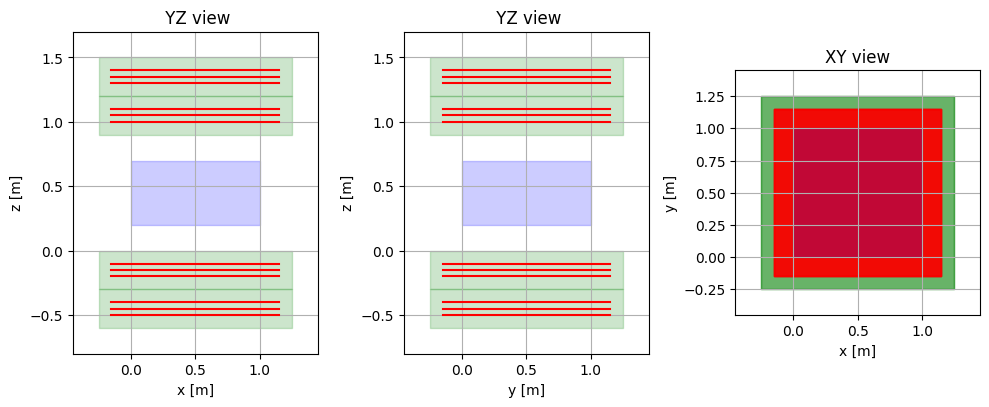

In [7]:
from plotting.plotting import draw_volume_2D
draw_volume_2D(volume)

# II - Optimisation test

In [ ]:
from __future__ import annotations

from typing import List, Tuple

import imageio
import matplotlib.lines as mlines
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
from fastprogress.fastprogress import IN_NOTEBOOK
from matplotlib.gridspec import GridSpec

import torch

from tomopt.volume import SigmoidDetectorPanel
from tomopt.optimisation.callbacks import Callback
from tomopt.optimisation.callbacks.monitors import MetricLogger


class HodoscopeMetricLogger(MetricLogger):
    r"""
    Logger for use with :class:`~tomopt.volume.layer.HodoscopeDetectorLayer` s

    Arguments:
        gif_filename: optional savename for recording a gif of the optimisation process (None -> no gif)
            The savename will be appended to the callback savepath
        gif_length: If saving gifs, controls the total length in seconds
        show_plots: whether to provide live plots during optimisation in notebooks
    """

    def _reset(self) -> None:
        det = self.wrapper.volume.get_detectors()[0]
        if isinstance(det, HodoscopeDetectorLayer):
            panel = det.hodoscopes[0].panels[0]
            self.uses_sigmoid_panels = isinstance(panel, SigmoidDetectorPanel)
        else:
            self.uses_sigmoid_panels = False
        super()._reset()

    def _prep_plots(self) -> None:
        r"""
        Creates the plots for a new optimisation
        """

        super()._prep_plots()
        if self.show_plots:
            with sns.axes_style(**self.style):
                self.above_det = [self.fig.add_subplot(self.grid_spec[-2:-1, i : i + 1]) for i in range(3)]
                self.below_det = [self.fig.add_subplot(self.grid_spec[-1:, i : i + 1]) for i in range(3)]
                if self.uses_sigmoid_panels:
                    self.panel_smoothness = self.fig.add_subplot(self.grid_spec[-2:-1, -1:])
                self._set_axes_labels()

    def update_plot(self) -> None:
        r"""
        Updates the plot(s).
        """

        super().update_plot()
        with sns.axes_style(**self.style), sns.color_palette(self.cat_palette) as palette:
            for axes, det in zip([self.above_det, self.below_det], self.wrapper.get_detectors()):
                l, s = [], []
                if not isinstance(det, HodoscopeDetectorLayer):
                    raise ValueError(f"Detector {det} is not a HodoscopeDetectorLayer")
                for h in det.hodoscopes:
                    for p in h.panels:
                        if det.type_label == "heatmap":
                            l_val = np.concatenate((p.mu.detach().cpu().numpy().mean(axis=0), p.z.detach().cpu().numpy()))
                            s_val = p.sig.detach().cpu().numpy().mean(axis=0)
                            l.append(l_val)
                            s.append(s_val)
                        else:
                            l.append(np.concatenate((p.xy.detach().cpu().numpy(), p.z.detach().cpu().numpy())))
                            s.append(p.get_scaled_xy_span().detach().cpu().numpy())
                    loc, span = np.array(l), np.array(s)

                    for ax in axes:
                        ax.clear()

                    lw = self.wrapper.volume.lw.detach().cpu().numpy()
                    axes[2].add_patch(patches.Rectangle((0, 0), lw[0], lw[1], linewidth=1, edgecolor="black", facecolor="none", hatch="x"))  # volume

                    for p in range(len(loc)):
                        axes[0].add_line(
                            mlines.Line2D((loc[p, 0] - (span[p, 0] / 2), loc[p, 0] + (span[p, 0] / 2)), (loc[p, 2], loc[p, 2]), linewidth=2, color=palette[p])
                        )  # xz
                        axes[1].add_line(
                            mlines.Line2D((loc[p, 1] - (span[p, 1] / 2), loc[p, 1] + (span[p, 1] / 2)), (loc[p, 2], loc[p, 2]), linewidth=2, color=palette[p])
                        )  # yz
                        axes[2].add_patch(
                            patches.Rectangle(
                                (loc[p, 0] - (span[p, 0] / 2), loc[p, 1] - (span[p, 1] / 2)),
                                span[p, 0],
                                span[p, 1],
                                linewidth=1,
                                edgecolor=palette[p],
                                facecolor="none",
                            )
                        )  # xy

                    if self.uses_sigmoid_panels:
                        self.panel_smoothness.clear()
                        with torch.no_grad():
                            panel = det.panels[0]
                            width = panel.get_scaled_xy_span()[0].cpu().item()
                            centre = panel.xy[0].cpu().item()
                            x = torch.linspace(-width, width, 50)[:, None]
                            y = panel.sig_model(x + centre)[:, 0]
                            self.panel_smoothness.plot(2 * x.cpu().numpy() / width, y.cpu().numpy())

            self._set_axes_labels()

    def _build_grid_spec(self) -> GridSpec:
        r"""
        Returns:
            The layout object for the plots
        """

        self.n_dets = len(self.wrapper.get_detectors())
        return self.fig.add_gridspec(5 + (self.main_metric_idx is None), 3 + self.uses_sigmoid_panels)

    def _set_axes_labels(self) -> None:
        r"""
        Adds styling to plots after they are cleared
        """

        for ax, x in zip(self.below_det, ["x", "y", "x"]):
            ax.set_xlabel(x, fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
        for i, (ax, x) in enumerate(zip(self.above_det, ["z", "z", "y"])):
            if i == 0:
                x = "Above, " + x
            ax.set_ylabel(x, fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
        for i, (ax, x) in enumerate(zip(self.below_det, ["z", "z", "y"])):
            if i == 0:
                x = "Below, " + x
            ax.set_ylabel(x, fontsize=0.8 * self.lbl_sz, color=self.lbl_col)

        for ax, det in zip((self.above_det, self.below_det), self.wrapper.get_detectors()):
            if not isinstance(det, HodoscopeDetectorLayer):
                raise ValueError(f"Detector {det} is not a HodoscopeDetectorLayer")
            lw, z = det.lw.detach().cpu(), det.z.detach().cpu()
            sizes = torch.stack([p.get_scaled_xy_span().detach().cpu() for h in det.hodoscopes for p in h.panels], dim=0) / 2
            poss = torch.stack([p.xy.detach().cpu() for h in det.hodoscopes for p in h.panels], dim=0)
            xy_min, xy_max = (poss - sizes).min(0).values, (poss + sizes).max(0).values
            margin = lw.max() / 2

            ax[0].set_xlim(min([1, xy_min[0].item()]) - (lw[0] / 2), max([lw[0].item(), xy_max[0].item()]) + (lw[0] / 2))
            ax[1].set_xlim(min([1, xy_min[1].item()]) - (lw[1] / 2), max([lw[1].item(), xy_max[1].item()]) + (lw[1] / 2))
            ax[2].set_xlim(xy_min.min() - margin, xy_max.max() + margin)
            ax[0].set_ylim(z - (1.25 * det.size), z + (0.25 * det.size))
            ax[1].set_ylim(z - (1.25 * det.size), z + (0.25 * det.size))
            ax[2].set_ylim(xy_min.min() - margin, xy_max.max() + margin)
            ax[2].set_aspect("equal", "box")

        if self.uses_sigmoid_panels:
            self.panel_smoothness.set_xlim((-2, 2))
            self.panel_smoothness.set_xlabel("Panel model (arb. pos.)", fontsize=0.8 * self.lbl_sz, color=self.lbl_col)

In [8]:
from volume.hodoscope import Hodoscope
from volume.hodoscopelayer import HodoscopeDetectorLayer
from tomopt.volume import Volume

from tomopt.core import X0
from torch import Tensor

from functools import partial
from tomopt.optimisation import VoxelX0Loss

from optimisation.hodoscope_volume_wrapper import HodoscopeVolumeWrapper

wrapper = HodoscopeVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=5e4),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xyz_span_opt=partial(torch.optim.SGD, lr=1e4),
                             loss_func=VoxelX0Loss(target_budget=20, cost_coef=None))